In [256]:
import numpy as np
import scipy.stats as st
import pandas as pd
from textblob import TextBlob
import itertools
from collections import Counter
from tqdm import tqdm

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from gensim.utils import simple_preprocess
from nltk import bigrams as nltkbigrams

# Graphic libraries
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
import seaborn as sns
sns.set_theme()

# Dataset

In [257]:
# Tests dataset with 20 rows and a few columns
df = pd.read_csv('input/english_reviews_v2.csv', usecols = ['text_n', 'rating'])
df = df.rename(columns={"text_n": "review"})
# Convert all text in pre processed reviews into lower case
df['review'] = df['review'].str.lower()
# Add a column with ReviewID
df['review_id'] = range(1, len(df)+1)
df = df[['review_id', 'review', 'rating']]
df.head()

,review_id,review,rating
0,1,hana riverside quang ngai hotel located in a q...,4
1,2,dropped in here for 1 night on my way north. f...,5
2,3,stayed here for one night while passing throug...,4
3,4,kind of difficult to find but we had a great s...,5
4,5,do not go to this place. the manager is a liar...,1


## Restructure to sentence level

In [258]:
# Breaking reviews into sentences
review_ids = []
doc_out = []
obj_sents = []

for index, row in df.iterrows(): 
    blob = TextBlob(row.review)
    for sentence in blob.sentences:
        # Evaluate sentence subjectivity - if it is lower than 0.2 sentense is objective and we will ignore it
        subj = sentence.sentiment.subjectivity
        if subj >= 0.2:
            review_ids.append(row.review_id)
            doc_out.append(str(sentence))
        else:
            obj_sents.append(str(sentence))
    
sent_df = pd.DataFrame()
sent_df['review_id'] = review_ids
sent_df['sentence'] = doc_out

print('Total subjective sentences:', len(sent_df), '\nObjective sentences removed:', len(obj_sents))
sent_df.head()

Total subjective sentences: 232080 
Objective sentences removed: 63589


,review_id,sentence
0,1,hana riverside quang ngai hotel located in a q...
1,1,clean and spacious rooms friendly staff.
2,1,a favorite destination for tourists by motorbike.
3,1,the hotel is under construction so the outside...
4,1,we could not sleep well at night because the d...


In [259]:
# Sentence example
sent_df['sentence'][0]

'hana riverside quang ngai hotel located in a quiet villa area and near the river so very cool.'

# Preprocessing

In [263]:
# import stopwords
stop_words = stopwords.words('english')
# Additional stop words and words that need to be removed
stop_words = stop_words + ['etc']  
# Remove words for negation from the stop words list
words_to_remove = ['no', 'not', 'very']

for word in words_to_remove:
    try:
        stop_words.remove(word)
    except:
        print("Word '"+ word + "' not in the list")


wnl = WordNetLemmatizer()

# Preprocessing of all sentences

all_sentences = []

for sentence in tqdm(sent_df['sentence']):
    # Convert a document into a list of tokens
    # This lowercases, tokenizes, removes numerical values
    tokens = simple_preprocess(sentence)

    # Apply POS tagging
    pos_tags = pos_tag(tokens)

    doc_out = ''
    
    for word, tag in pos_tags:
        if word not in stop_words:
            # Check if the word is a verb
            if tag.startswith('V'):
                # Lemmatize the verb (get base form)
                lemma = wnl.lemmatize(word, pos='v')
                doc_out = doc_out + lemma + ' '
            elif tag.startswith('N'):
                # Lemmatize the verb (get base form)
                lemma = wnl.lemmatize(word, pos='n')
                doc_out = doc_out + lemma + ' '
            elif tag.startswith('J'):
                # Lemmatize the verb (get base form)
                lemma = wnl.lemmatize(word, pos='a')
                doc_out = doc_out + lemma + ' '
            elif tag.startswith('R'):
                # Lemmatize the verb (get base form)
                lemma = wnl.lemmatize(word, pos='r')
                doc_out = doc_out + lemma + ' '
            else:
                doc_out = doc_out + word + ' '  # Keep the rest of tokens as is
    
    doc_out = doc_out.strip()
    all_sentences.append(doc_out)

# Add tokens columns to the dataframe
sent_df['sentence_clean'] = all_sentences
sent_df['tokens'] = sent_df['sentence_clean'].apply(lambda x: word_tokenize(x))
sent_df.head()

100%|█████████████████████████████████| 232080/232080 [01:37<00:00, 2384.19it/s]


,review_id,sentence,sentence_clean,tokens
0,1,hana riverside quang ngai hotel located in a q...,hana riverside quang ngai hotel locate quiet v...,"[hana, riverside, quang, ngai, hotel, locate, ..."
1,1,clean and spacious rooms friendly staff.,clean spacious room friendly staff,"[clean, spacious, room, friendly, staff]"
2,1,a favorite destination for tourists by motorbike.,favorite destination tourist motorbike,"[favorite, destination, tourist, motorbike]"
3,1,the hotel is under construction so the outside...,hotel construction outside railing very dusty,"[hotel, construction, outside, railing, very, ..."
4,1,we could not sleep well at night because the d...,could not sleep well night dog next door bark ...,"[could, not, sleep, well, night, dog, next, do..."


## Bigrams

In [264]:
# Create a list of bigrams based on tokens
bigrams = [list(nltkbigrams(tokens)) for tokens in sent_df.tokens]

# Flatten list of bigrams
bigrams_list = list(itertools.chain(*bigrams))

# Create counter of words in bigrams list
bigram_counts = Counter(bigrams_list)
print('Number of unique bigrams in the answers:', len(bigram_counts))

# Dataframe with bigrams sorted by frequency
bigram_df = pd.DataFrame(bigram_counts.most_common(1000), columns=['bigram', 'count'])
bigram_df.head(20)

Number of unique bigrams in the answers: 631522


,bigram,count
0,"(very, good)",3201
1,"(very, nice)",2681
2,"(staff, very)",2641
3,"(highly, recommend)",2543
4,"(very, friendly)",2424
5,"(can, not)",2281
6,"(could, not)",2127
7,"(come, back)",1914
8,"(phu, quoc)",1914
9,"(friendly, helpful)",1722


In [265]:
# Function to replace tokens with bigrams join by underscore: (one, night) -> one_night
# Input: review - list of tokens in a review;
# bigrams - list of tuples e.g. ('let', 'us')
# Output: list of lists of tokens with bigram matches replaced by two words joint by underscore
# based on https://stackoverflow.com/questions/47906952/how-to-replace-bigrams-in-place-using-nltk
def bigram_replacement(review, bigrams):
    lookup = set(bigrams)
    tokens = []
    q_iter = iter(range(len(review)))
    for idx in q_iter:
        tokens.append(review[idx])
        if idx < (len(review) - 1) and (review[idx], review[idx+1]) in lookup:
                tokens[-1] += "_" + review[idx+1]
                next(q_iter)
    return(tokens)

In [266]:
# Top-1000 bigrams
top_n = bigram_df['bigram']

# Adding a column with joint tokens based on bigrams
sent_df['tokens_j'] = sent_df['tokens'].apply(lambda x: bigram_replacement(x, top_n))
sent_df.head()

,review_id,sentence,sentence_clean,tokens,tokens_j
0,1,hana riverside quang ngai hotel located in a q...,hana riverside quang ngai hotel locate quiet v...,"[hana, riverside, quang, ngai, hotel, locate, ...","[hana, riverside, quang, ngai, hotel_locate, q..."
1,1,clean and spacious rooms friendly staff.,clean spacious room friendly staff,"[clean, spacious, room, friendly, staff]","[clean_spacious, room, friendly_staff]"
2,1,a favorite destination for tourists by motorbike.,favorite destination tourist motorbike,"[favorite, destination, tourist, motorbike]","[favorite, destination, tourist, motorbike]"
3,1,the hotel is under construction so the outside...,hotel construction outside railing very dusty,"[hotel, construction, outside, railing, very, ...","[hotel, construction, outside, railing, very, ..."
4,1,we could not sleep well at night because the d...,could not sleep well night dog next door bark ...,"[could, not, sleep, well, night, dog, next, do...","[could_not, sleep, well, night, dog, next_door..."


# Aspect Extraction

In [267]:
# Import the list of aspects and words bank
aspect_df = pd.read_csv('input/Aspect_List.csv')
# Remove duplicates
aspect_df = aspect_df.drop_duplicates()
print("Number of tokens in aspect vocabulary:", len(aspect_df))
aspect_df.head()

Number of tokens in aspect vocabulary: 359


,aspect,aspect_no,keywords
0,Location,1,airport
1,Location,1,area
2,Location,1,bay
3,Location,1,beach
4,Location,1,beach_front


In [268]:
# Creating a dataframe with aspect numbers and names
aspect_list_df = aspect_df.groupby(['aspect', 'aspect_no']).nunique().reset_index()
aspect_list_df= aspect_list_df.sort_values('aspect_no').reset_index(drop = True)
aspect_list_df = aspect_list_df.set_index('aspect_no')
aspect_list_df

,aspect,keywords
aspect_no,,
1,Location,44
2,Cleanliness,34
3,Comfort,24
4,Facilities,84
5,Service,102
6,Value,17
7,Food_and_beverage,54


In [269]:
# Function to detect aspect words in a list of tokens and save them in to a list
# if no askpect words are detected the ist is empty
# Input: review - list of list of tokens
#        aspect_words - list of words that identify aspect
# Output: list of aspect words found
def aspect_word_detection(review, aspect_words):
    aspect_tokens = []
    common_words = set(review) & set(aspect_words)
    if len(common_words) > 0:
        aspect_tokens = aspect_tokens + list(common_words)
    if len(aspect_tokens) == 0:
        aspect_tokens = 0
    return(aspect_tokens)

In [270]:
# Going through all aspects and searching for askect words in in reviews
for index,row in aspect_list_df.iterrows():
    # Select a particuar aspect
    aspect_words = list(aspect_df[aspect_df['aspect_no'] == index]['keywords'])
    
    new_column_name = row['aspect'].lower()
    # Apply the function to the 'tokens' column using vectorization
    sent_df[new_column_name] = sent_df['tokens_j'].apply(aspect_word_detection, args=(aspect_words,))
sent_df.head()

,review_id,sentence,sentence_clean,tokens,tokens_j,location,cleanliness,comfort,facilities,service,value,food_and_beverage
0,1,hana riverside quang ngai hotel located in a q...,hana riverside quang ngai hotel locate quiet v...,"[hana, riverside, quang, ngai, hotel, locate, ...","[hana, riverside, quang, ngai, hotel_locate, q...","[river, area]",0,[quiet],[villa],0,0,0
1,1,clean and spacious rooms friendly staff.,clean spacious room friendly staff,"[clean, spacious, room, friendly, staff]","[clean_spacious, room, friendly_staff]",0,0,0,[room],[friendly_staff],0,0
2,1,a favorite destination for tourists by motorbike.,favorite destination tourist motorbike,"[favorite, destination, tourist, motorbike]","[favorite, destination, tourist, motorbike]",0,0,0,0,0,0,0
3,1,the hotel is under construction so the outside...,hotel construction outside railing very dusty,"[hotel, construction, outside, railing, very, ...","[hotel, construction, outside, railing, very, ...",0,[dusty],0,[hotel],0,0,0
4,1,we could not sleep well at night because the d...,could not sleep well night dog next door bark ...,"[could, not, sleep, well, night, dog, next, do...","[could_not, sleep, well, night, dog, next_door...",0,0,"[night, sleep]",0,0,0,0


In [271]:
# Reviews with no aspect
condition = (sent_df['location'] == 0) & (sent_df['cleanliness'] == 0) & (sent_df['comfort'] == 0) & (sent_df['facilities'] == 0) & (sent_df['service'] == 0) & (sent_df['value'] == 0) & (sent_df['food_and_beverage'] == 0)

no_aspect = len(sent_df[condition])
print('Number of sentences without aspects identified:', no_aspect)
print('Sentences without aspects identified from total:', round(no_aspect*100 / len(sent_df), 2), "%")

Number of sentences without aspects identified: 53188
Sentences without aspects identified from total: 22.92 %


In [272]:
# Reviews with all 7 aspects
condition = (sent_df['location'] != 0) & (sent_df['cleanliness'] != 0) & (sent_df['comfort'] != 0) & (sent_df['facilities'] != 0) & (sent_df['service'] != 0) & (sent_df['value'] != 0) & (sent_df['food_and_beverage'] != 0)

all_aspects = len(sent_df[condition])
print('Number of reviews with all 7 aspects identified:', all_aspects)
print('Reviews with all aspects identified from total:', round(all_aspects*100 / len(df), 2), "%")

Number of reviews with all 7 aspects identified: 18
Reviews with all aspects identified from total: 0.06 %


In [273]:
# Function that calculates number of aspects in a particular review
# Input: a row of a dataframe
# Output: integer numer of reviews

def number_of_aspects(row):
    aspects_in_review = 0

    if (row['location'] != 0):
        aspects_in_review = aspects_in_review + 1
    if (row['cleanliness'] != 0):
        aspects_in_review = aspects_in_review + 1
    if (row['comfort'] != 0):
        aspects_in_review = aspects_in_review + 1
    if (row['facilities'] != 0):
        aspects_in_review = aspects_in_review + 1
    if (row['service'] != 0):
        aspects_in_review = aspects_in_review + 1
    if (row['value'] != 0):
        aspects_in_review = aspects_in_review + 1
    if (row['food_and_beverage'] != 0):
        aspects_in_review = aspects_in_review + 1

    return(aspects_in_review)

In [274]:
# Apply function to add as column with number of aspects identified
sent_df['aspect_no'] = sent_df.apply(number_of_aspects, axis = 1)
sent_df.head()

,review_id,sentence,sentence_clean,tokens,tokens_j,location,cleanliness,comfort,facilities,service,value,food_and_beverage,aspect_no
0,1,hana riverside quang ngai hotel located in a q...,hana riverside quang ngai hotel locate quiet v...,"[hana, riverside, quang, ngai, hotel, locate, ...","[hana, riverside, quang, ngai, hotel_locate, q...","[river, area]",0,[quiet],[villa],0,0,0,3
1,1,clean and spacious rooms friendly staff.,clean spacious room friendly staff,"[clean, spacious, room, friendly, staff]","[clean_spacious, room, friendly_staff]",0,0,0,[room],[friendly_staff],0,0,2
2,1,a favorite destination for tourists by motorbike.,favorite destination tourist motorbike,"[favorite, destination, tourist, motorbike]","[favorite, destination, tourist, motorbike]",0,0,0,0,0,0,0,0
3,1,the hotel is under construction so the outside...,hotel construction outside railing very dusty,"[hotel, construction, outside, railing, very, ...","[hotel, construction, outside, railing, very, ...",0,[dusty],0,[hotel],0,0,0,2
4,1,we could not sleep well at night because the d...,could not sleep well night dog next door bark ...,"[could, not, sleep, well, night, dog, next, do...","[could_not, sleep, well, night, dog, next_door...",0,0,"[night, sleep]",0,0,0,0,1


In [275]:
# Descriptive statistics for aspect number per sentence
sent_df['aspect_no'].describe()

count    232080.000000
mean          1.228482
std           0.972009
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           7.000000
Name: aspect_no, dtype: float64

In [276]:
# Function calculates mean and 95% confidence interval for an array
def conf_interval(array, conf_level = 0.95):
    ci_scale = st.t.interval(confidence = conf_level, 
                  df = len(array) - 1, 
                  loc = np.mean(array),  
                  scale = st.sem(array))
    print('Confidence interval with 0.95% conf level:', round(np.mean(array),2), ' +/-', round(np.mean(array) - ci_scale[0],2))
    print('Min: ' + str(round(ci_scale[0], 2)), '; Max:', round(ci_scale[1],2) )

In [277]:
# 95% confidence interval for number of aspects
conf_interval(sent_df['aspect_no'])

Confidence interval with 0.95% conf level: 1.23  +/- 0.0
Min: 1.22 ; Max: 1.23


In [279]:
# Aspect frequency
aspect_columns = ['location', 'cleanliness', 'comfort', 'facilities', 'service', 'value',
       'food_and_beverage']
# Total number of reviews
no_of_reviews = len(sent_df)

aspect_frequencies = []
aspect_shares = []

for column in aspect_columns:
    # Number of columns where an aspect is present
    aspect_present = len(sent_df[sent_df[column] != 0])
    aspect_frequencies.append(aspect_present)
    aspect_share = round((aspect_present *100)/no_of_reviews,2)
    aspect_shares.append(aspect_share)
    print('Aspect', column, 'is present in', aspect_share, '% of sentences' )

aspect_frequency_df = pd.DataFrame()
aspect_frequency_df['aspect'] = aspect_columns
aspect_frequency_df['frequency'] = aspect_frequencies
aspect_frequency_df['share'] = aspect_shares

aspect_frequency_df

Aspect location is present in 21.64 % of sentences
Aspect cleanliness is present in 3.7 % of sentences
Aspect comfort is present in 10.81 % of sentences
Aspect facilities is present in 35.1 % of sentences
Aspect service is present in 27.44 % of sentences
Aspect value is present in 5.95 % of sentences
Aspect food_and_beverage is present in 18.2 % of sentences


,aspect,frequency,share
0,location,50226,21.64
1,cleanliness,8597,3.70
2,comfort,25086,10.81
3,facilities,81468,35.10
4,service,63683,27.44
5,value,13807,5.95
6,food_and_beverage,42239,18.20


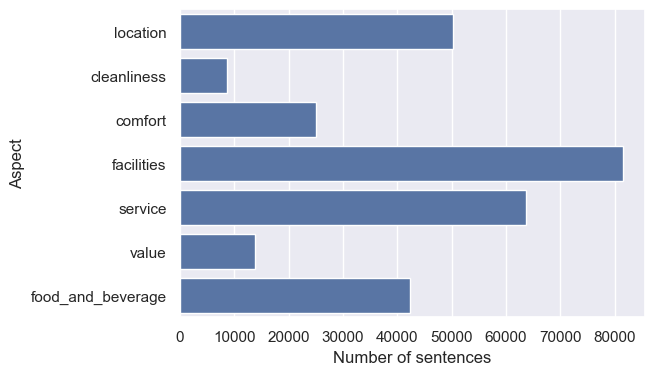

In [280]:
# Aspect frequence in sentences
plt.figure(figsize=(6,4))
ax = sns.barplot(aspect_frequency_df, y="aspect", x="frequency")
ax.set_xlabel('Number of sentences')
ax.set_ylabel('Aspect')
plt.show()

In [281]:
# Drop sentences without aspects identified
print('Number of sentences:', len(sent_df))
sent_df = sent_df[sent_df['aspect_no'] > 0]
print('Number of sentences after sentences without aspects are removed:', len(sent_df))
sent_df['aspect_no'].describe()

Number of sentences: 232080
Number of sentences after sentences without aspects are removed: 178892


count    178892.000000
mean          1.593733
std           0.802244
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           7.000000
Name: aspect_no, dtype: float64

# Restructuring for classifier

In [283]:
# Restructuring dataframe to duplicate sentences if they mention multiple aspects
# One aspect category per row
aspect_columns = ['location', 'cleanliness', 'comfort', 'facilities', 'service', 'value',
       'food_and_beverage']

review_ids = []
sent_out = []
tokens_out = []
aspect_out = []

for index, row in tqdm(sent_df.iterrows()):
    for column in aspect_columns:
        if row[column] != 0:
            review_ids.append(row.review_id)
            sent_out.append(row.sentence_clean)
            tokens_out.append(row.tokens_j)
            aspect_out.append(column)
    
ml_df = pd.DataFrame()
ml_df['review_id'] = review_ids
ml_df['sentence'] = sent_out
ml_df['tokens'] = tokens_out
ml_df['aspect'] = aspect_out

print('Total of sentences in dataframe:', len(ml_df), '\nIncluding duplicated sentences:', len(ml_df) - len(sent_df) )
ml_df.head()

178892it [00:06, 28491.58it/s]


Total of sentences in dataframe: 285106 
Including duplicated sentences: 106214


,review_id,sentence,tokens,aspect
0,1,hana riverside quang ngai hotel locate quiet v...,"[hana, riverside, quang, ngai, hotel_locate, q...",location
1,1,hana riverside quang ngai hotel locate quiet v...,"[hana, riverside, quang, ngai, hotel_locate, q...",comfort
2,1,hana riverside quang ngai hotel locate quiet v...,"[hana, riverside, quang, ngai, hotel_locate, q...",facilities
3,1,clean spacious room friendly staff,"[clean_spacious, room, friendly_staff]",facilities
4,1,clean spacious room friendly staff,"[clean_spacious, room, friendly_staff]",service


# Classifier training
Example from "Text Analytics with Python"
Ch09b - Sentiment Analysis - Supervised.ipynb
https://github.com/dipanjanS/text-analytics-with-python/blob/master/New-Second-Edition/Ch09%20-%20Sentiment%20Analysis/Ch09b%20-%20Sentiment%20Analysis%20-%20Supervised.ipynb

In [284]:
# Machine learning linraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import model_evaluation_utils as meu
from sklearn import metrics

In [285]:
# X values
reviews = ml_df['sentence'].values

# Encoding labels for target value (aspect categories)
labels = ml_df['aspect'].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)
ml_df['aspect_no'] = encoded_labels

# Train - test split
X_train, X_test, y_train, y_test = train_test_split(reviews, encoded_labels, stratify = encoded_labels, 
                                                   train_size=0.70, test_size = 0.30, random_state = 16 )

print('Rows in train dataset:', len(X_train))
print('Rows in test dataset:', len(X_test))

Rows in train dataset: 199574
Rows in test dataset: 85532


In [286]:
# List of aspect category labels with codes
label_codes = pd.DataFrame()

label_codes['label'] = labels[:100]
label_codes['codes'] = encoded_labels[:100]
label_codes = label_codes.drop_duplicates().sort_values('codes')
label_codes = label_codes.set_index('codes')

label_codes

,label
codes,
0,cleanliness
1,comfort
2,facilities
3,food_and_beverage
4,location
5,service
6,value


In [117]:
# build BOW features on train reviews
cv = CountVectorizer(binary=False, min_df=0.0, max_df=1.0, ngram_range=(1,2))
cv_train_features = cv.fit_transform(X_train)

# build TFIDF features on train reviews
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=(1,2),
                     sublinear_tf=True)
tv_train_features = tv.fit_transform(X_train)

# transform test reviews into features
cv_test_features = cv.transform(X_test)
tv_test_features = tv.transform(X_test)

print('BOW model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)
print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)

BOW model:> Train features shape: (199574, 512004)  Test features shape: (85532, 512004)
TFIDF model:> Train features shape: (199574, 512004)  Test features shape: (85532, 512004)


## Model Training, Prediction and Performance Evaluation

In [126]:
# Load classification models with initial settings
lr = LogisticRegression(penalty='l2', max_iter=500, C=1)
svm = SGDClassifier(loss='hinge', max_iter=100)
mnb = MultinomialNB() # alpha = 3.0

In [287]:
# Logistic Regression model on BOW features
lr_bow_predictions = meu.train_predict_model(classifier=lr, 
                                             train_features=cv_train_features, train_labels=y_train,
                                             test_features=cv_test_features, test_labels=y_test)
meu.display_model_performance_metrics(true_labels=y_test, predicted_labels=lr_bow_predictions,
                                      classes = classes
                                     )

/opt/anaconda3/envs/spacy/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Performance metrics:
------------------------------
Accuracy: 0.4251
Precision: 0.4254
Recall: 0.4251
F1 Score: 0.4252

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.25      0.25      0.25      2579
           1       0.32      0.32      0.32      7526
           2       0.44      0.44      0.44     24440
           3       0.45      0.43      0.44     12672
           4       0.40      0.39      0.39     15068
           5       0.52      0.51      0.52     19105
           6       0.30      0.30      0.30      4142

    accuracy                           0.43     85532
   macro avg       0.38      0.38      0.38     85532
weighted avg       0.43      0.43      0.43     85532


Prediction Confusion Matrix:
------------------------------
          Predicted:                                     
                   0     1      2     3     4     5     6
Actual: 0        657   219    967   110 

In [132]:
# Logistic Regression model on TF-IDF features
lr_tfidf_predictions = meu.train_predict_model(classifier=lr, 
                                               train_features=tv_train_features, train_labels=y_train,
                                               test_features=tv_test_features, test_labels=y_test)
meu.display_model_performance_metrics(true_labels=y_test, predicted_labels=lr_tfidf_predictions,
                                      classes=classes)
print('done!')

/opt/anaconda3/envs/spacy/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Performance metrics:
------------------------------
Accuracy: 0.5254
Precision: 0.523
Recall: 0.5254
F1 Score: 0.5234

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.42      0.30      0.35      2579
           1       0.45      0.40      0.42      7526
           2       0.52      0.56      0.54     24440
           3       0.55      0.54      0.54     12672
           4       0.50      0.50      0.50     15068
           5       0.59      0.61      0.60     19105
           6       0.44      0.38      0.41      4142

    accuracy                           0.53     85532
   macro avg       0.50      0.47      0.48     85532
weighted avg       0.52      0.53      0.52     85532


Prediction Confusion Matrix:
------------------------------
          Predicted:                                      
                   0     1      2     3     4      5     6
Actual: 0        784   180    973    95

In [133]:
# SVM + BOW
svm_bow_predictions = meu.train_predict_model(classifier=svm, 
                                             train_features=cv_train_features, train_labels=y_train,
                                             test_features=cv_test_features, test_labels=y_test)
meu.display_model_performance_metrics(true_labels=y_test, predicted_labels=svm_bow_predictions,
                                      classes=classes)

Model Performance metrics:
------------------------------
Accuracy: 0.5108
Precision: 0.5076
Recall: 0.5108
F1 Score: 0.5089

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.30      0.21      0.25      2579
           1       0.40      0.38      0.39      7526
           2       0.53      0.55      0.54     24440
           3       0.52      0.54      0.53     12672
           4       0.48      0.48      0.48     15068
           5       0.59      0.59      0.59     19105
           6       0.37      0.33      0.35      4142

    accuracy                           0.51     85532
   macro avg       0.46      0.44      0.45     85532
weighted avg       0.51      0.51      0.51     85532


Prediction Confusion Matrix:
------------------------------
          Predicted:                                      
                   0     1      2     3     4      5     6
Actual: 0        547   211    986   13

In [134]:
# SVM + TFIDF
svm_tfidf_predictions = meu.train_predict_model(classifier=svm, 
                                                train_features=tv_train_features, train_labels=y_train,
                                                test_features=tv_test_features, test_labels=y_test)
meu.display_model_performance_metrics(true_labels=y_test, predicted_labels=svm_tfidf_predictions,
                                      classes=classes)

Model Performance metrics:
------------------------------
Accuracy: 0.584
Precision: 0.582
Recall: 0.584
F1 Score: 0.5696

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.50      0.14      0.22      2579
           1       0.59      0.29      0.39      7526
           2       0.57      0.70      0.63     24440
           3       0.57      0.64      0.60     12672
           4       0.59      0.50      0.54     15068
           5       0.61      0.71      0.66     19105
           6       0.55      0.27      0.36      4142

    accuracy                           0.58     85532
   macro avg       0.57      0.46      0.49     85532
weighted avg       0.58      0.58      0.57     85532


Prediction Confusion Matrix:
------------------------------
          Predicted:                                      
                   0     1      2     3     4      5     6
Actual: 0        371   142   1243   154  

In [146]:
# Multinomial NB + BOW
mnb = MultinomialNB(alpha = 3.0)

mnb_bow_predictions = meu.train_predict_model(classifier=mnb, 
                                             train_features=cv_train_features, train_labels=y_train,
                                             test_features=cv_test_features, test_labels=y_test)
meu.display_model_performance_metrics(true_labels=y_test, predicted_labels=mnb_bow_predictions,
                                      classes=classes)

Model Performance metrics:
------------------------------
Accuracy: 0.4963
Precision: 0.5109
Recall: 0.4963
F1 Score: 0.4577

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.33      0.00      0.00      2579
           1       0.57      0.05      0.09      7526
           2       0.44      0.72      0.54     24440
           3       0.57      0.49      0.53     12672
           4       0.49      0.40      0.44     15068
           5       0.57      0.64      0.60     19105
           6       0.56      0.05      0.09      4142

    accuracy                           0.50     85532
   macro avg       0.51      0.33      0.33     85532
weighted avg       0.51      0.50      0.46     85532


Prediction Confusion Matrix:
------------------------------
          Predicted:                                    
                   0    1      2     3     4      5    6
Actual: 0          2   19   2092    60   2

In [147]:
# Multinomial NB + TFIDF
mnb_tfidf_predictions = meu.train_predict_model(classifier=mnb, 
                                                train_features=tv_train_features, train_labels=y_train,
                                                test_features=tv_test_features, test_labels=y_test)
meu.display_model_performance_metrics(true_labels=y_test, predicted_labels=mnb_tfidf_predictions,
                                      classes=classes)

Model Performance metrics:
------------------------------
Accuracy: 0.4534
Precision: 0.5755
Recall: 0.4534
F1 Score: 0.39

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2579
           1       0.94      0.00      0.00      7526
           2       0.37      0.88      0.52     24440
           3       0.67      0.30      0.41     12672
           4       0.60      0.17      0.26     15068
           5       0.61      0.58      0.59     19105
           6       0.91      0.00      0.01      4142

    accuracy                           0.45     85532
   macro avg       0.59      0.28      0.26     85532
weighted avg       0.58      0.45      0.39     85532


Prediction Confusion Matrix:
------------------------------
          Predicted:                                  
                   0   1      2     3     4      5   6
Actual: 0          0   0   2395    13    45    1

/opt/anaconda3/envs/spacy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/spacy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/spacy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/spacy/lib/pytho

In [170]:
# Hyperparamether optimisation with parameter grid
# source: https://medium.com/@ashleyha/multinomial-classification-with-unbalanced-data-using-random-forest-machine-learning-with-55f9e8d5c26e
parameter_grid = { 
    #'loss': ['hinge', 'perceptron', 'squared_error', 'huber'],
    #'class_weight': ['balanced', None],
    'alpha' : [0.0005, 0.001, 0.005, 0.01], # default 0.0001
    #'penalty' :['l2', None] # default 'l2'
}

my_model = SGDClassifier()
clf = GridSearchCV(my_model, parameter_grid, cv = 5, scoring = 'accuracy', n_jobs = -1, verbose = 1)

clf.fit(tv_train_features, y_train)


print(clf.best_params_)
print(clf.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'alpha': 0.0005}
0.584304581670082


# Best configuration
Other ideas on rebalancing: https://stackoverflow.com/questions/62070556/how-to-improve-performance-for-imbalanced-dataset-using-svm
+ class_weight: while accuracy drops, F1-score per class improves

In [288]:
# SVM TFIDF - best configuration
svm = SGDClassifier(loss = 'hinge', alpha = 0.001, penalty = None, class_weight = 'balanced', 
                    max_iter = 100)
svm_tfidf_predictions = meu.train_predict_model(classifier=svm, 
                                                train_features=tv_train_features, train_labels=y_train,
                                                test_features=tv_test_features, test_labels=y_test)
meu.display_model_performance_metrics(true_labels=y_test, predicted_labels=svm_tfidf_predictions,
                                      classes=classes)

Model Performance metrics:
------------------------------
Accuracy: 0.5744
Precision: 0.6184
Recall: 0.5744
F1 Score: 0.5742

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.34      0.87      0.49      2579
           1       0.46      0.69      0.55      7526
           2       0.72      0.41      0.52     24440
           3       0.59      0.63      0.61     12672
           4       0.59      0.53      0.56     15068
           5       0.68      0.64      0.66     19105
           6       0.42      0.86      0.56      4142

    accuracy                           0.57     85532
   macro avg       0.54      0.66      0.56     85532
weighted avg       0.62      0.57      0.57     85532


Prediction Confusion Matrix:
------------------------------
          Predicted:                                     
                   0     1     2     3     4      5     6
Actual: 0       2241    94    53    45  

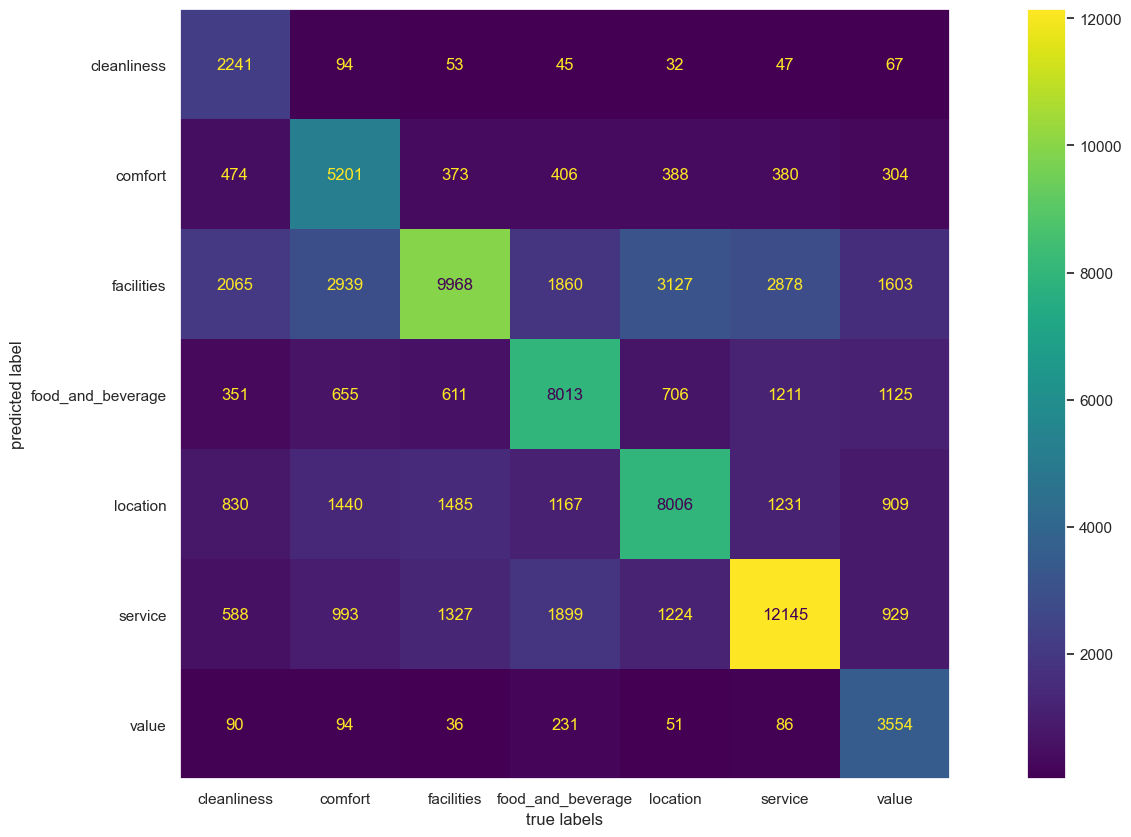

In [289]:
# plotting the confusion matrix
mat = confusion_matrix(y_test, svm_tfidf_predictions)
disp =  ConfusionMatrixDisplay(mat)
disp.plot()

plt.xticks(np.arange(7), list(label_codes.label))  
plt.yticks(np.arange(7), list(label_codes.label))  

plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.gcf().set_size_inches(20, 10)
plt.grid(visible = None)
plt.show()

## Rebalancing classes by random undersampling

The smallest class count is: 8597
Random under-sampling:
aspect_no
0    8597
1    8597
2    8597
3    8597
4    8597
5    8597
6    8597
Name: count, dtype: int64

Total number of rows: 60179


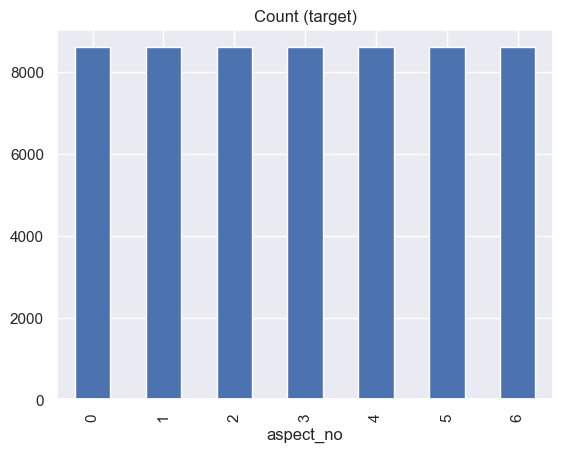

In [294]:
# Random undersampling: https://medium.com/digital-catapult/dealing-with-imbalanced-data-8b21e6deb6cd
# Class count for the smallest class
min_class_count = ml_df.aspect_no.value_counts().min()

print('The smallest class count is:', min_class_count)

# Seperate classes
target_0 = ml_df[ml_df['aspect_no'] == 0]
target_1 = ml_df[ml_df['aspect_no'] == 1]
target_2 = ml_df[ml_df['aspect_no'] == 2]
target_3 = ml_df[ml_df['aspect_no'] == 3]
target_4 = ml_df[ml_df['aspect_no'] == 4]
target_5 = ml_df[ml_df['aspect_no'] == 5]
target_6 = ml_df[ml_df['aspect_no'] == 6]

# Resample all tagrest to match target 0 count
target_1_undersample = target_1.sample(min_class_count)
target_2_undersample = target_2.sample(min_class_count)
target_3_undersample = target_3.sample(min_class_count)
target_4_undersample = target_4.sample(min_class_count)
target_5_undersample = target_5.sample(min_class_count)
target_6_undersample = target_6.sample(min_class_count)

# Merge back to single df
all_classes = [target_0, target_1_undersample, target_2_undersample, target_3_undersample, 
               target_4_undersample, target_5_undersample, target_6_undersample]
test_undersample = pd.concat(all_classes, axis=0)

# Show counts and plot
print("Random under-sampling:")
print(test_undersample.iloc[:,-1].value_counts())
print("\nTotal number of rows:", len(test_undersample))
test_undersample.iloc[:,-1].value_counts().plot(kind = 'bar', title = 'Count (target)')
plt.show()

In [295]:
# X value
reviews_w = test_undersample['sentence'].values
# Encoding labels for y value (aspect category)
encoded_labels_w = test_undersample['aspect_no'].values


# Train - test split
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(reviews_w, encoded_labels_w, 
                                                            stratify = encoded_labels_w, 
                                                            test_size = 0.25, random_state = 69 )

print('Rows in train dataset:', len(X_train_w))
print('Rows in test dataset:', len(X_test_w))

Rows in train dataset: 45134
Rows in test dataset: 15045


In [296]:
# build BOW features on train reviews
cv = CountVectorizer(binary=False, min_df=0.0, max_df=1.0, ngram_range=(1,2))
cv_train_w = cv.fit_transform(X_train_w)

# build TFIDF features on train reviews
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=(1,2),
                     sublinear_tf=True)
tv_train_w = tv.fit_transform(X_train_w)

# transform test reviews into features
cv_test_w = cv.transform(X_test_w)
tv_test_w = tv.transform(X_test_w)

print('BOW model:> Train features shape:', cv_train_w.shape, ' Test features shape:', cv_test_w.shape)
print('TFIDF model:> Train features shape:', tv_train_w.shape, ' Test features shape:', tv_test_w.shape)

BOW model:> Train features shape: (45134, 221127)  Test features shape: (15045, 221127)
TFIDF model:> Train features shape: (45134, 221127)  Test features shape: (15045, 221127)


In [297]:
# SVM TFIDF
svm = SGDClassifier(loss = 'hinge', alpha = 0.001, max_iter = 100)

svm_tfidf_predictions = meu.train_predict_model(classifier=svm, 
                                                train_features=tv_train_w, train_labels=y_train_w,
                                                test_features=tv_test_w, test_labels=y_test_w)
meu.display_model_performance_metrics(true_labels=y_test_w, predicted_labels=svm_tfidf_predictions,
                                      classes=classes)

Model Performance metrics:
------------------------------
Accuracy: 0.6762
Precision: 0.6765
Recall: 0.6762
F1 Score: 0.654

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.71      0.96      0.82      2149
           1       0.66      0.77      0.71      2149
           2       0.71      0.26      0.38      2149
           3       0.64      0.65      0.65      2150
           4       0.67      0.49      0.57      2149
           5       0.63      0.66      0.64      2149
           6       0.71      0.94      0.81      2150

    accuracy                           0.68     15045
   macro avg       0.68      0.68      0.65     15045
weighted avg       0.68      0.68      0.65     15045


Prediction Confusion Matrix:
------------------------------
          Predicted:                                   
                   0     1    2     3     4     5     6
Actual: 0       2066    18    1    16    10  

In [298]:
# SVM BOW
svm = SGDClassifier(loss = 'hinge', alpha = 0.001, max_iter = 100)

svm_cv_predictions = meu.train_predict_model(classifier=svm, 
                                                train_features=cv_train_w, train_labels=y_train_w,
                                                test_features=cv_test_w, test_labels=y_test_w)
meu.display_model_performance_metrics(true_labels=y_test_w, predicted_labels=svm_cv_predictions,
                                      classes=classes)

Model Performance metrics:
------------------------------
Accuracy: 0.6842
Precision: 0.6825
Recall: 0.6842
F1 Score: 0.6685

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.76      0.94      0.84      2149
           1       0.66      0.78      0.71      2149
           2       0.72      0.32      0.44      2149
           3       0.64      0.62      0.63      2150
           4       0.62      0.57      0.59      2149
           5       0.65      0.65      0.65      2149
           6       0.73      0.91      0.81      2150

    accuracy                           0.68     15045
   macro avg       0.68      0.68      0.67     15045
weighted avg       0.68      0.68      0.67     15045


Prediction Confusion Matrix:
------------------------------
          Predicted:                                   
                   0     1    2     3     4     5     6
Actual: 0       2029    36    4    29    20 

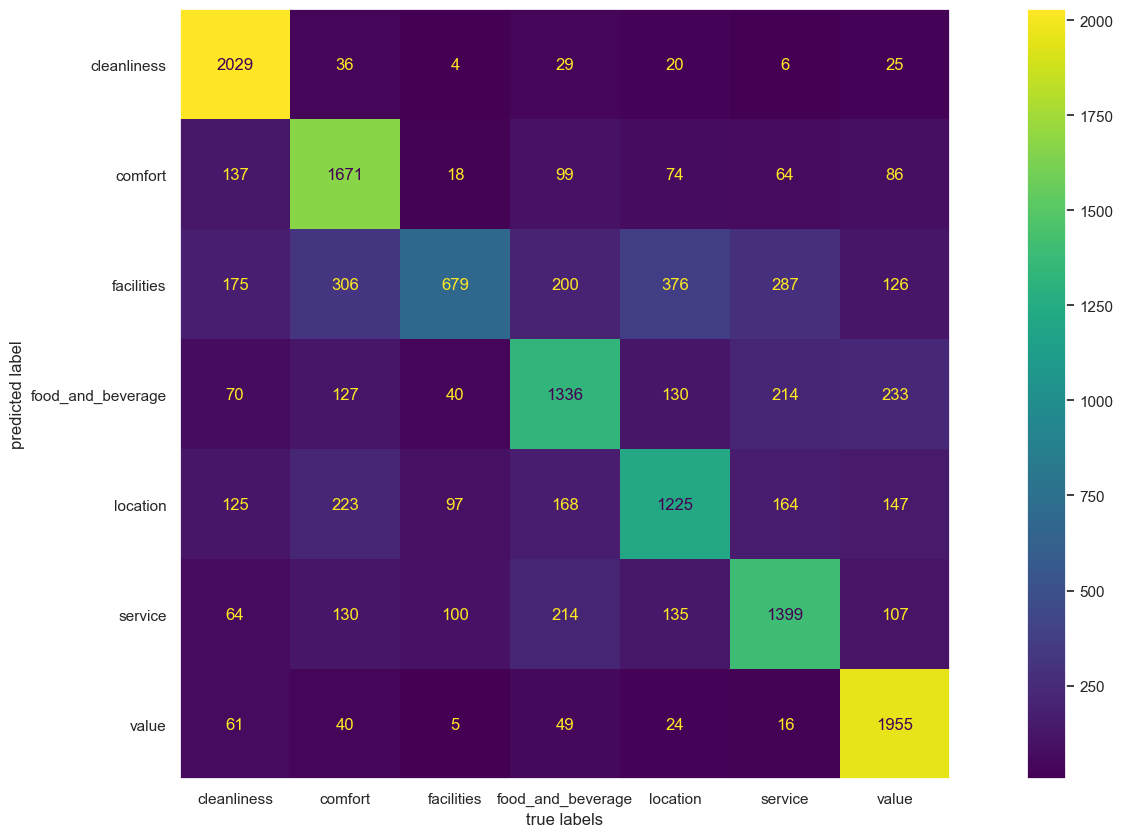

In [299]:
# plotting the confusion matrix
mat = confusion_matrix(y_test_w, svm_cv_predictions)
disp =  ConfusionMatrixDisplay(mat)
disp.plot()

plt.xticks(np.arange(7), list(label_codes.label))  
plt.yticks(np.arange(7), list(label_codes.label))  

plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.gcf().set_size_inches(20, 10)
plt.grid(visible = None)
plt.show()